[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Shipway_and_Hill_2012/fig_1.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Shipway_and_Hill_2012/fig_1.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Shipway_and_Hill_2012/fig_1.ipynb)

#### based on Fig. 1 from Shipway & Hill 2012 (Q. J. Royal Meteo. Soc. 138)  "_Diagnosis of systematic differences between multiple parametrizations of warm rain microphysics using a kinematic framework_"   
https://doi.org/10.1002/qj.1913

**NOTES**: 
- constant momentum profile rather than constant velocity profile is used herein
- enabling precipitation interpretted as turning on sedimentation and collisions
- pressure at z=0 not given in the paper, assumed (see settings.py)
- domain extended below z=0 to mimic particle inflow

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
from PySDM_examples.Shipway_and_Hill_2012 import Settings, Simulation, plot
from PySDM.physics import si
from PySDM.exporters import NetCDFExporter_1d

In [3]:
common_params = {
    "n_sd_per_gridbox": 256,
    "dt": 5 * si.s,
    "dz": 50 * si.m,
    "p0": 990 * si.hPa,
    "kappa": .9,
    "particles_per_volume_STP": 50 / si.cm**3
}
if 'CI' in os.environ:
    common_params["t_max"] = 10 * common_params["dt"]
    common_params["n_sd_per_gridbox"] = 16 

output = {}
settings = {}
simulation = {}
for rho_times_w in (
    2 * si.kg/si.m**3 * si.m/si.s,
    3 * si.kg/si.m**3 * si.m/si.s
):
    for precip in (
        False, 
        True,
    ):
        key = f"rhow={rho_times_w}_p={precip}"
        settings[key] = Settings(
            **common_params,
            rho_times_w_1=rho_times_w,
            precip=precip
        )
        simulation[key] = Simulation(settings[key])
        output[key] = simulation[key].run().products

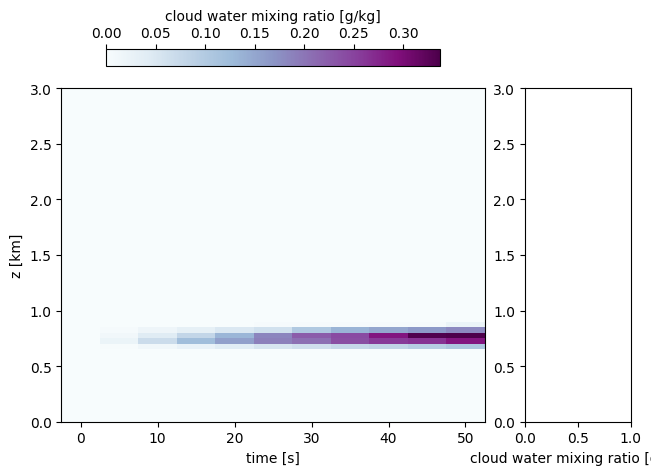

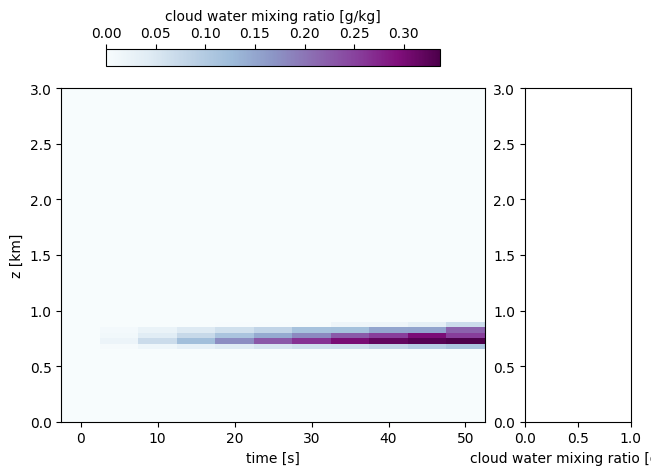

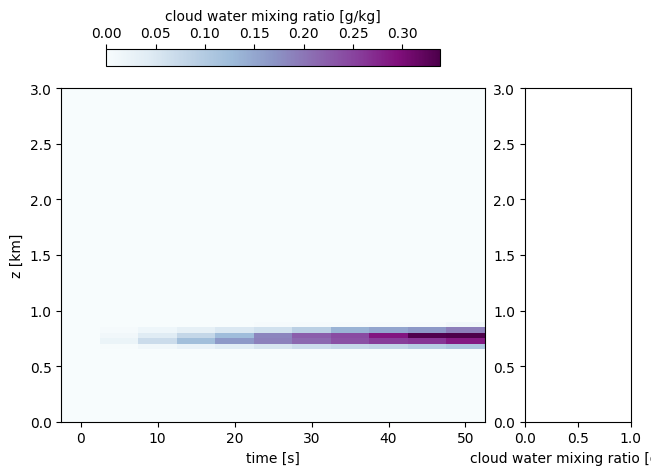

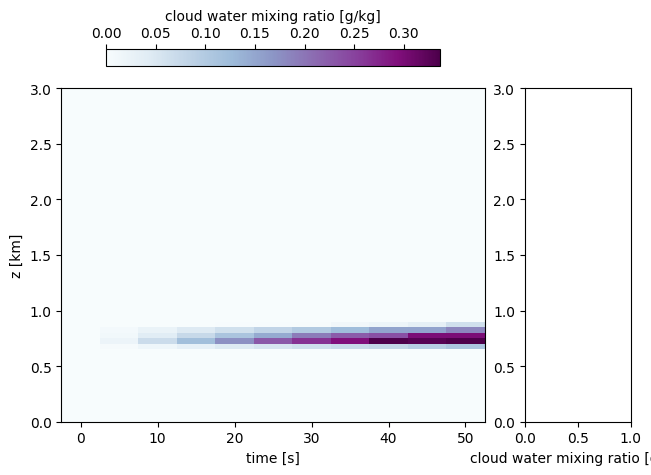

In [4]:
for p in (False, True):
    for rho_times_w in (2, 3):
        plot(var='cloud water mixing ratio', qlabel='cloud water mixing ratio [g/kg]', fname=f'qc_rhow={rho_times_w}_p={p}.pdf',
             output=output[f'rhow={rho_times_w}.0_p={p}'])

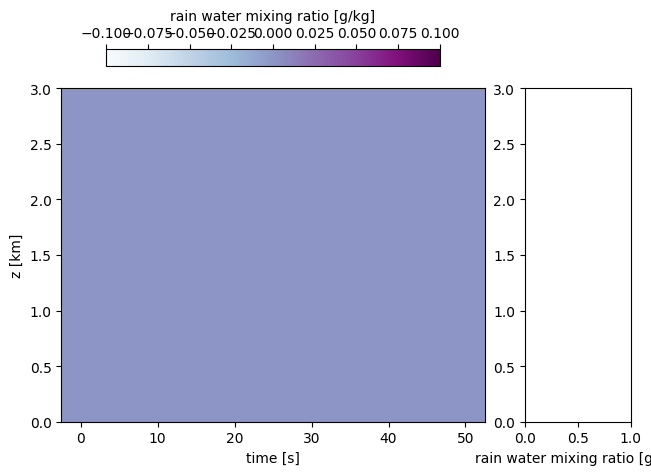

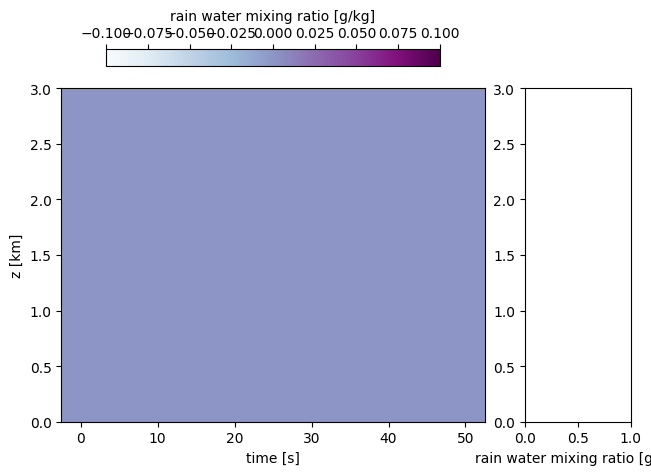

In [5]:
p = True
for rho_times_w in (2, 3):
    plot(var='rain water mixing ratio', qlabel='rain water mixing ratio [g/kg]', fname=f'qr_rhow={rho_times_w}_p={p}.pdf',
        output=output[f'rhow={rho_times_w}.0_p={p}'])

In [6]:
for p in (False, True):
    for rho_times_w in (2, 3):
        key = f"rhow={rho_times_w}.0_p={p}"
        filename = 'products_' + key + '.nc'
        nc_exporter = NetCDFExporter_1d(output[key], settings[key], simulation[key], filename)
        nc_exporter.run()